In [1]:
import re
import uuid
import random
import tqdm
import requests
import json
import json5
import fire 
import streamlit as st 
from PIL import Image
from io import BytesIO
from collections import defaultdict



from pydantic import BaseModel, Field, ValidationError, TypeAdapter
from typing_extensions import (Annotated, TypedDict, Sequence, Union, Optional, Literal, List, Dict, Iterator, Any, Type)



from langchain_core.language_models import LanguageModelInput
from langchain_core.runnables import Runnable
from langchain_core.output_parsers import PydanticOutputParser
from langchain_core.tools import InjectedToolCallId, BaseTool
from langchain.tools import tool
from langchain_ollama import ChatOllama
from langchain_core.messages import (HumanMessage, AIMessage, SystemMessage, BaseMessage, ToolMessage)
from langchain_core.prompts import PromptTemplate



from langgraph.types import Command, interrupt
from langgraph.graph.message import add_messages
from langgraph.store.memory import InMemoryStore
from langgraph.checkpoint.memory import MemorySaver
from langgraph.managed import IsLastStep
from langgraph.graph import (MessagesState, StateGraph, START, END)
from langgraph.prebuilt import (create_react_agent, ToolNode, tools_condition)



from tools import (add, subtract, multiply, divide, power, square_root)
from prompts import Prompts 



NAME = "FOXCONN-AI Research"
DEBUG = False



BEGIN_OF_TEXT		=	"<|begin_of_text|>"
END_OF_TEXT			= 	"<|end_of_text|>"
START_HEADER_ID		= 	"<|start_header_id|>"
END_HEADER_ID		= 	"<|end_header_id|>"
END_OF_MESSAGE_ID	= 	"<|eom_id|>"
END_OF_TURN_ID		= 	"<|eot_id|>"



MSG_TYPES = {	SystemMessage: "SYS", HumanMessage: "HUMAN", AIMessage: "AI"	}



DEFAULT_AGENTS: Dict[str, Dict[str, List[BaseMessage]]] = {
	"MANAGER_AGENT": 	{	"SYS": [], "HUMAN": [], "AI": []	},
	"REQUEST_VERIFY": 	{	"SYS": [], "HUMAN": [], "AI": []	},
	"PROMPT_AGENT": 	{	"SYS": [], "HUMAN": [], "AI": []	},
	"DATA_AGENT": 		{	"SYS": [], "HUMAN": [], "AI": []	},
	"MODEL_AGENT": 		{	"SYS": [], "HUMAN": [], "AI": []	},
	"OP_AGENT": 		{	"SYS": [], "HUMAN": [], "AI": []	},
}



def default_messages() -> Dict[str, Dict[str, List[BaseMessage]]]:
	"""Tạo dictionary mặc định cho `messages`, giữ nguyên danh sách các Agent.

	- Sử dụng `defaultdict` để tránh lỗi KeyError nếu truy cập Agent chưa tồn tại.
	- `lambda: {"SYS": [], "HUMAN": [], "AI": []}` đảm bảo mỗi Agent có đủ 3 loại tin nhắn.
	- `DEFAULT_AGENTS.copy()` giúp giữ nguyên cấu trúc ban đầu mà không bị ghi đè.

	Returns:
		Dict[str, Dict[str, List[BaseMessage]]]: Cấu trúc lưu trữ tin nhắn theo Agent và loại tin nhắn.
	"""
	return defaultdict(lambda: {"SYS": [], "HUMAN": [], "AI": []}, DEFAULT_AGENTS.copy())



class State(BaseModel):
	"""Manages structured conversation state in a multi-agent system.

	Attributes:
		human_query (List[HumanMessage]): List of user queries.
		messages (Dict[str, Dict[str, List[BaseMessage]]]): 
			Stores categorized messages by agent type and message type:
			- **Agent types**: MANAGER_AGENT, REQUEST_VERIFY, PROMPT_AGENT, DATA_AGENT, MODEL_AGENT, OP_AGENT.
			- **Message types**: SYSTEM, HUMAN, AI.
		is_last_step (bool): Indicates if this is the final step.
		remaining_steps (int): Number of steps left.

	Methods:
		get_all_msgs(): Retrieves all messages across all agents in chronological order.
		get_latest_msg(agent_type, msg_type): Returns the latest message from a given agent and type.
		get_msgs_by_agent_type_and_msg_type(agent_type, msg_type): Retrieves all messages from a specific agent and type.
		add_unique_msgs(node, msgs_type, msg): Adds a unique message to a specified node.
	"""
	human_query: Annotated[List[HumanMessage], add_messages] = Field(default_factory=list)
	messages: Dict[str, Dict[str, List[BaseMessage]]] = Field(
		default_factory=default_messages, 
		description="Categorized messages by agent type and message type."
	)
	is_last_step: bool = False
	remaining_steps: int = 3

	def get_all_msgs(self) -> List[BaseMessage]:
		"""Retrieves all messages from all agents in chronological order."""
		all_messages = []
		for agent_messages in self.messages.values():
			for msg_list in agent_messages.values():
				all_messages.extend(msg_list)
		return all_messages

	def get_latest_msg(self, agent_type: str, msg_type: str) -> BaseMessage:
		"""Returns the latest message from a specified agent and type.

		Raises:
			ValueError: If the agent type or message type is invalid.
		"""
		if agent_type not in self.messages: raise ValueError(f"[ERROR]: Invalid agent category '{agent_type}'. Must be one of {list(self.messages.keys())}.")
		if msg_type not in self.messages[agent_type]: raise ValueError(f"[ERROR]: Invalid message type '{msg_type}'. Must be 'SYSTEM', 'HUMAN', or 'AI'.")
		return self.messages[agent_type][msg_type][-1] if self.messages[agent_type][msg_type] else None

	def get_msgs_by_node_and_msgs_type(self, node: str, msgs_type: str) -> List[BaseMessage]:
		"""Retrieves all messages from a specified agent and type.

		Raises:
			ValueError: If the node or message type is invalid.
		"""
		if node not in self.messages: raise ValueError(f"[ERROR]: Invalid agent category '{node}'. Must be one of {list(self.messages.keys())}.")
		if msgs_type not in self.messages[node]: raise ValueError(f"[ERROR]: Invalid message type '{msgs_type}'. Must be 'SYSTEM', 'HUMAN', or 'AI'.")
		return self.messages[node][msgs_type]

	def add_unique_msgs(self, node: str, msgs_type: str, msg: BaseMessage) -> None:
		"""Adds a unique message to a specific node in the State.

		Args:
			node (str): The agent node (e.g., "MANAGER_AGENT", "REQUEST_VERIFY").
			msgs_type (str): The message type (one of "AI", "HUMAN", "SYS").
			msg (BaseMessage): The message object to be stored.

		Raises:
			ValueError: If the message type is invalid.
		"""
		if node not in self.messages: self.messages[node] = {"SYS": [], "HUMAN": [], "AI": []}
		if msgs_type not in {"SYS", "HUMAN", "AI"}: raise ValueError(f"[ERROR]: Invalid message type '{msgs_type}'. Must be 'SYS', 'HUMAN', or 'AI'.")
		if node == "REQUEST_VERIFY": self.messages[node][msgs_type] = [msg]
		else:
			if msg.content not in {m.content for m in self.messages[node][msgs_type]}:
				self.messages[node][msgs_type].append(msg)


# TODO: Cần thêm prompt để hướng dẫn mô hình trả lời tốt hơn, đề xuất sử dụng chain-of-thought prompt.
class Conversation(TypedDict):
	"""You are an AI assistant. Respond in a conversational manner. Be kind and helpful."""
	response:		Annotated[str, ..., "A conversational response to the user's query"			]
	justification: 	Annotated[str, ..., "A brief explanation or reasoning behind the response."	]



class Prompt2JSON(TypedDict):
	"""Parses user requirements related to AI project potential into structured JSON."""
	problem_area: 	Annotated[str, ..., "Problem domain (e.g., tabular data analysis)."			]
	task: 			Annotated[str, ..., "Type of ML task (e.g., classification, regression)."	]
	application: 	Annotated[str, ..., "Application field (e.g., agriculture, healthcare)."	]
	dataset_name: 	Annotated[str, ..., "Dataset name (e.g., banana_quality)."					]
	data_modality: 	Annotated[List[str], ..., "Data modality (e.g., ['tabular', 'image'])."		]
	model_name: 	Annotated[str, ..., "Model name (e.g., XGBoost, ResNet)."					]
	model_type: 	Annotated[str, ..., "Model type (e.g., vision, text, tabular)."				]
	cuda: 			Annotated[bool, ..., "Requires CUDA? (True/False)."							]
	vram: 			Annotated[str, ..., "GPU's VRAM required (e.g., '6GB')."					]
	cpu_cores: 		Annotated[int, ..., "Number of CPU cores required."							]
	ram: 			Annotated[str, ..., "RAM required (e.g., '16GB')."							]



MGR_SYS_MSG_PROMPT 				= 	Prompts.AGENT_MANAGER_PROMPT
VER_RELEVANCY_MSG_PROMPT 		= 	Prompts.REQUEST_VERIFY_RELEVANCY
VER_ADEQUACY_MSG_PROMPT 		= 	Prompts.REQUEST_VERIFY_ADEQUACY
CONVERSATION_2_JSON_MSG_PROMPT 	= 	Prompts.CONVERSATION_TO_JSON_PROMPT
PROMPT_2_JSON_SYS_MSG_PROMPT 	= 	Prompts.PROMPT_AGENT_PROMPT



CONFIG = {"configurable": {"thread_id": str(uuid.uuid4()), "recursion_limit": 100}}
CHECKPOINTER = MemorySaver()
STORE = InMemoryStore()



LLM_HTEMP	=	ChatOllama(model="llama3.2:1b-instruct-fp16", temperature=0.8, num_predict=128_000)
LLM_LTEMP 	= 	ChatOllama(model="llama3.2:1b-instruct-fp16", temperature=0, num_predict=128_000)

LLM_STRUC_OUT_CONVERSATION 	= LLM_HTEMP.with_structured_output(schema=Conversation, method="json_schema")
LLM_STRUC_OUT_AUTOML 		= LLM_HTEMP.with_structured_output(schema=Prompt2JSON, method="json_schema")



def add_special_token_to_human_query(human_msg: str) -> str:
	"""Enhances the human query by formatting it with special tokens of LLama 3 series models.

	Args:
		human_msg (str): User's query.

	Returns:
		formatted_query: A formatted human query wrapped with special tokens.

	Example:
		>>> state.user_query = [HumanMessage(content="What is AI?")]
		>>> enhance_human_query(state)
		formatted_query="<|start_header_id|>HUMAN<|end_header_id|>What is AI?<|end_of_turn_id|><|start_header_id|>AI<|end_header_id|>"
	"""
	formatted_query = (
		f"{START_HEADER_ID}HUMAN{END_HEADER_ID}"
		f"{human_msg}{END_OF_TURN_ID}"
		f"{START_HEADER_ID}AI{END_HEADER_ID}"
	)
	return formatted_query



def add_eotext_eoturn_to_ai_msg(ai_msg: AIMessage, end_of_turn_id_token: str = END_OF_TURN_ID, end_of_text_token: str = END_OF_TEXT) -> AIMessage:
	"""Ensures AIMessage content ends with required special tokens.

	This function appends `<|end_of_text|>` and `<|eot_id|>` at the end of the message content if they are not already present.

	Args:
		ai_msg (AIMessage): The AI-generated message.
		end_of_text_token (str, optional) = "<|end_of_text|>": Special token indicating the end of the text.
		end_of_turn_id_token (str, optional) = "<|eot_id|>": Special token marking the end of a conversation turn.

	Returns:
		AIMessage: The updated AI message with the required tokens.

	Example:
		>>> message = AIMessage(content="Hello, how can I assist you?")
		>>> add_eotext_eoturn_to_ai_msg(message, "<|end_of_text|>", "<|eot_id|>")
		AIMessage(content="Hello, how can I assist you?<|end_of_text|><|eot_id|>")
	"""
	content = ai_msg.content.strip()
	if not content.endswith(end_of_turn_id_token): content += end_of_turn_id_token
	if not content.endswith(end_of_turn_id_token + end_of_text_token): content = content.replace(end_of_turn_id_token, end_of_turn_id_token + end_of_text_token)
	return AIMessage(content=content)


# TODO: Tối ưu hàm này, cần loại bỏ `.get()` tránh tạo đối tượng không cần thiết.
def build_react_sys_msg_prompt(tool_desc_prompt: str, react_prompt: str, tools: List[BaseTool]) -> str:
	"""Builds a formatted system prompt with tool descriptions.

	Args:
		tool_desc_prompt (PromptTemplate): Template for tool descriptions.
		react_prompt (PromptTemplate): Template for constructing the final system prompt.
		tools (List[BaseTool]): List of tool objects.

	Returns:
		str: A fully formatted system prompt with tool descriptions.
	"""
	list_tool_desc = [
		tool_desc_prompt.format(
			name_for_model=(tool_info := getattr(tool.args_schema, "model_json_schema", lambda: {})()).get("title", "Unknown Tool"),
			name_for_human=tool_info.get("title", "Unknown Tool"),
			description_for_model=tool_info.get("description", "No description available."),
			type=tool_info.get("type", "N/A"),
			properties=json.dumps(tool_info.get("properties", {}), ensure_ascii=False),
			required=json.dumps(tool_info.get("required", []), ensure_ascii=False),
		) + " Format the arguments as a JSON object."
		for tool in tools
	]
	prompt = react_prompt.format(
		BEGIN_OF_TEXT=BEGIN_OF_TEXT, 
		START_HEADER_ID=START_HEADER_ID, 
		END_HEADER_ID=END_HEADER_ID, 
		END_OF_TURN_ID=END_OF_TURN_ID, 
		tools_desc="\n\n".join(list_tool_desc), 
		tools_name=", ".join(tool.name for tool in tools)
	)
	return prompt



def conversation2json(msg_prompt: str, llm_structure_output: Runnable[LanguageModelInput, Dict | BaseModel], human_msg: HumanMessage, schema: Type[Dict]) -> json:
	"""Parses user's query into structured JSON for manager_agent.

	Args:
		llm_structure_output (Runnable[LanguageModelInput, Dict | BaseModel]): LLM function to generate structured output.
		human_msg (HumanMessage): User's input message.
		schema (Type[Dict]): TypedDict schema to validate JSON.

	Returns:
		Dict: Validated JSON containing:
			{
				"response": "A conversational response to the user's query.",
				"justification": "A brief explanation or reasoning behind the response."
			}

	Raises:
		ValueError: If the response does not contain valid JSON or is missing required fields.
	"""
	json_data = llm_structure_output.invoke([human_msg])
	if not json_data:
		json_schema = json.dumps(TypeAdapter(schema).json_schema()["properties"], indent=2).strip()
		sys_msg = SystemMessage(content=msg_prompt.format(
			BEGIN_OF_TEXT=BEGIN_OF_TEXT, 
			START_HEADER_ID=START_HEADER_ID, 
			END_HEADER_ID=END_HEADER_ID, 
			json_schema=json_schema, 
			human_msg=human_msg.content, 
			END_OF_TURN_ID=END_OF_TURN_ID
		))
		ai_msg_json = LLM_LTEMP.invoke([sys_msg])
		pattern = r"```json\n(.*?)\n```"
		match = re.search(pattern=pattern, string=ai_msg_json.content, flags=re.DOTALL)
		if not match: raise ValueError(">>> Không tìm thấy JSON hợp lệ trong phản hồi của mô hình.")
		json_string = match.group(1).strip()
		try:
			json_data = json.loads(json_string)
			if DEBUG: 
				print(">>> JSON hợp lệ:")
				print(json.dumps(json_data, indent=2, ensure_ascii=False))
		except json.JSONDecodeError as e:
			raise ValueError(f">>> JSON không hợp lệ (DecodeError): {e}")
	missing_keys = set(schema.__annotations__.keys()) - json_data.keys()
	extra_keys = json_data.keys() - set(schema.__annotations__.keys())
	if missing_keys: raise ValueError(f">>> JSON thiếu các trường bắt buộc: {missing_keys}")
	if extra_keys: raise ValueError(f">>> JSON có các trường không hợp lệ: {extra_keys}")
	return json_data



def manager_agent(state: State) -> State:
	"""Manager Agent.

	Example:
		>>> Human query: I need a very accurate model to classify images in the 
				Butterfly Image Classification dataset into their respective 
				categories. The dataset has been uploaded with its label 
				information in the labels.csv file.
		>>> AI response: Here is a sample code that uses the Keras library to develop and train a convolutional neural network (CNN) model for ...
	"""
	sys_msg = SystemMessage(content=MGR_SYS_MSG_PROMPT.format(BEGIN_OF_TEXT=BEGIN_OF_TEXT, START_HEADER_ID=START_HEADER_ID, END_HEADER_ID=END_HEADER_ID, END_OF_TURN_ID=END_OF_TURN_ID))
	human_msg = HumanMessage(content=add_special_token_to_human_query(human_msg=state.human_query[-1].content if state.human_query else ""))
	ai_msg_json = HumanMessage(str(conversation2json(msg_prompt=CONVERSATION_2_JSON_MSG_PROMPT, llm_structure_output=LLM_STRUC_OUT_CONVERSATION, human_msg=human_msg, schema=Conversation)))
	ai_msg = LLM_LTEMP.invoke([sys_msg, human_msg, ai_msg_json])
	if not isinstance(ai_msg, AIMessage): ai_msg = AIMessage(content=ai_msg.strip() if isinstance(ai_msg, str) else "At node_manager_agent, I'm unable to generate a response.")
	ai_msg = add_eotext_eoturn_to_ai_msg(ai_msg=ai_msg, end_of_turn_id_token=END_OF_TURN_ID, end_of_text_token=END_OF_TEXT)
	state.add_unique_msgs(node="MANAGER_AGENT", msgs_type="SYS", msg=sys_msg)
	state.add_unique_msgs(node="MANAGER_AGENT", msgs_type="HUMAN", msg=human_msg)
	state.add_unique_msgs(node="MANAGER_AGENT", msgs_type="AI", msg=AIMessage("<|parse_json|>" + ai_msg_json.content + "<|end_parse_json|>" + ai_msg.content))
	return state



def check_contain_yes_or_no(ai_msg: str) -> str:
	"""Checks if the AI response contains 'Yes' or 'No'."""
	pattern = r"<\|start_header_id\|>assistant<\|end_header_id\|>\s*\n\s*(yes|no)\b"
	match = re.search(pattern=pattern, string=ai_msg, flags=re.IGNORECASE)
	if match:return match.group(1).upper()
	else:return "[ERROR]: Không tìm thấy 'Yes' hoặc 'No' trong phản hồi AI!"



def relevancy(state: State) -> List[BaseMessage]:
	"""Check request verification-relevancy of human_query."""
	human_msg = state.human_query[-1]
	sys_msg = SystemMessage(content=VER_RELEVANCY_MSG_PROMPT.format(
		instruction=human_msg.content, 
		BEGIN_OF_TEXT=BEGIN_OF_TEXT, 
		START_HEADER_ID=START_HEADER_ID, 
		END_HEADER_ID=END_HEADER_ID, 
		END_OF_TURN_ID=END_OF_TURN_ID
	))
	ai_msg = LLM_LTEMP.invoke([sys_msg])
	if not isinstance(ai_msg, AIMessage): ai_msg = AIMessage(content=ai_msg.strip() if isinstance(ai_msg, str) else "At node_request_verify-REQUEST_VERIFY_RELEVANCY, I'm unable to generate a response.")
	ai_msg = add_eotext_eoturn_to_ai_msg(ai_msg=ai_msg, end_of_turn_id_token=END_OF_TURN_ID, end_of_text_token=END_OF_TEXT)
	return [sys_msg, human_msg, ai_msg]



def adequacy(state: State) -> List[BaseMessage]:
	"""Check request verification-adequacy of AIMessage response with JSON object."""
	pattern = r"<\|parse_json\|>(.*?)<\|end_parse_json\|>"
	human_msg = state.messages['MANAGER_AGENT']['HUMAN'][-1]
	ai_msg = state.messages['MANAGER_AGENT']['AI'][-1]
	json_obj_from_ai_msg = re.findall(pattern=pattern, string=ai_msg.content, flags=re.DOTALL)[-1]
	sys_msg = SystemMessage(content=VER_ADEQUACY_MSG_PROMPT.format(
		BEGIN_OF_TEXT=BEGIN_OF_TEXT, 
		START_HEADER_ID=START_HEADER_ID, 
		END_HEADER_ID=END_HEADER_ID, 
		parsed_user_requirements=json_obj_from_ai_msg, 
		END_OF_TURN_ID=END_OF_TURN_ID
	))
	ai_msg = LLM_LTEMP.invoke([sys_msg])
	if not isinstance(ai_msg, AIMessage): ai_msg = AIMessage(content=ai_msg.strip() if isinstance(ai_msg, str) else "At node_request_verify-REQUEST_VERIFY_ADEQUACY, I'm unable to generate a response.")
	ai_msg = add_eotext_eoturn_to_ai_msg(ai_msg=ai_msg, end_of_turn_id_token=END_OF_TURN_ID, end_of_text_token=END_OF_TEXT)
	return [sys_msg, human_msg, ai_msg]



def request_verify(state: State) -> State:
	"""Request verification output of Agent Manager."""
	ai_msg_relevancy = relevancy(state=state)[2]
	ai_msg_adequacy = adequacy(state=state)[2]
	yes_no_relevancy = check_contain_yes_or_no(ai_msg=ai_msg_relevancy.content)
	yes_no_adequacy  = check_contain_yes_or_no(ai_msg=ai_msg_adequacy.content )
	yes_no = "YES" if "YES" in (yes_no_relevancy, yes_no_adequacy) else "NO"
	ai_msg = AIMessage(content=yes_no)
	state.add_unique_msgs(node="REQUEST_VERIFY", msgs_type="AI", msg=ai_msg)
	return state



def req_ver_yes_or_no_control_flow(state: State) -> State:
	"""Determines the next step based on the AI response from REQUEST_VERIFY.

	Args:
		state (State): The current conversation state.

	Returns:
		str: The next agent ("PROMPT_AGENT" or END).

	Raises:
		ValueError: If there is no valid AI response or an unexpected response.
	"""
	if "REQUEST_VERIFY" not in state.messages or "AI" not in state.messages["REQUEST_VERIFY"]:
		raise ValueError("[ERROR]: No AI message found in REQUEST_VERIFY.")
	ai_msgs = state.messages["REQUEST_VERIFY"]["AI"]
	if not ai_msgs:
		raise ValueError("[ERROR]: AI message list is empty in REQUEST_VERIFY.")
	ai_msg = ai_msgs[-1]
	if not hasattr(ai_msg, "content"):
		raise ValueError("[ERROR]: AI message has no content.")
	resp = ai_msg.content.strip().upper()
	next_step_map = {"YES": "PROMPT_AGENT", "NO": END}
	if resp in next_step_map:
		return next_step_map[resp]
	raise ValueError(f">>> [ERROR]: Unexpected response '{resp}'")



def prompt_agent(state: State) -> State:
	"""Prompt Agent parses user's requirements into JSON following a TypedDict schema.
	
	Args:
		state (State): The current state of the conversation.

	Returns:
		State: Updated state with the parsed JSON response.
	"""
	if "MANAGER_AGENT" not in state.messages or "HUMAN" not in state.messages["MANAGER_AGENT"]:
		raise ValueError("[ERROR]: No HUMAN messages found in MANAGER_AGENT.")
	human_msg = state.messages["MANAGER_AGENT"]["HUMAN"][-1]
	parsed_json = conversation2json(
		msg_prompt=PROMPT_2_JSON_SYS_MSG_PROMPT, 
		llm_structure_output=LLM_STRUC_OUT_AUTOML,
		human_msg=human_msg,
		schema=Prompt2JSON
	)
	expected_keys, received_keys = set(Prompt2JSON.__annotations__), set(parsed_json)
	if missing_keys := expected_keys - received_keys: 
		raise ValueError(f"[ERROR]: JSON thiếu các trường bắt buộc: {missing_keys}")
	if extra_keys := received_keys - expected_keys: 
		raise ValueError(f"[ERROR]: JSON có các trường không hợp lệ: {extra_keys}")
	ai_msg_json = AIMessage(content=json.dumps(parsed_json, indent=2))
	ai_msg_json = add_eotext_eoturn_to_ai_msg(ai_msg=ai_msg_json, end_of_turn_id_token=END_OF_TURN_ID, end_of_text_token=END_OF_TEXT)
	state.add_unique_msgs(node="PROMPT_AGENT", msgs_type="AI", msg=ai_msg_json)
	return state


In [4]:
workflow = StateGraph(State)

workflow.add_node("MANAGER_AGENT", manager_agent)
workflow.add_node("REQUEST_VERIFY", request_verify)
workflow.add_node("PROMPT_AGENT", prompt_agent)

workflow.add_edge(START, "MANAGER_AGENT")
workflow.add_edge("MANAGER_AGENT", "REQUEST_VERIFY")
workflow.add_conditional_edges("REQUEST_VERIFY", req_ver_yes_or_no_control_flow, ["PROMPT_AGENT", END])
workflow.add_edge("PROMPT_AGENT", END)

app = workflow.compile(checkpointer=CHECKPOINTER, store=STORE, debug=DEBUG, name=NAME)

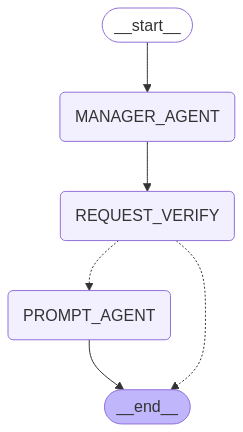

In [5]:
from IPython.display import Image, display

display(Image(app.get_graph(xray=True).draw_mermaid_png()))